# Deep Hedging in the Black-Scholes Model


We consider a one-dimensional Black-Scholes model which is given by the following dynamics
$$
    S_0 
=   s_0
\qquad \text{and} \qquad
    S_t 
=   S_0 \exp{\left(\left(\mu - \frac{1}{2}\sigma^2\right)t + \sigma W_t\right)},
    \qquad t \in [0, T]
$$
where $\mu \in \mathbb{R}$, $\sigma, s_0> 0$ and $W_t$ is a one-dimensional Brownian motion.

## Setup

Next, we import some required packages and our own modules.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

from torch import nn
from torch.optim import Adam

from modules.utils import save_model
from modules.market_impact import ZeroImpact
from modules.transaction_cost import ZeroCost
from modules.risk_measure import AverageValueAtRisk
from modules.derivative import EuropeanOption
from modules.black_scholes import BlackScholesModel, BlackScholesHedger, compare_to_black_scholes_hedger
from modules.deep_hedger import DeepHedger, train

If a GPU is available, we would like to use the GPU to speed up the training process. \\
Unfortunately, for some reason, training with the GPU is slower than without! \\
For this reason we will use the CPU for now!

In [2]:
# device settings
if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')
print('Device: {}'.format(my_device))

Device: cpu


## Setting

We choose a time horizon of 30 trading days with daily rebalancing, i.e. $T= 30/365$ and $n=30$ where the trading dates are given by $t_{k} = k/365$ for $k = 0, \ldots, n$.

Our goal is to hedge a call option with maturity $T$ and strike price $K = s_0$, i.e. $Z = (S_T - K)^+$.
Recall that the unique risk-neutral price of the call option at time $t$ is given by

\begin{equation}
    u(t, S_t) := S_t \Phi\left(d_{+}\right)-K e^{-r(T-t)} \Phi\left(d_{-}\right), \quad t \in[0, T],
\end{equation}

where $\Phi\colon\mathbb{R}\to[0,1]$ denotes the cumulative distribution function of a standard normal random variable and
\begin{align*}
    d_{\pm} = \frac{\log (S_t / K)+\left(r \pm \sigma^{2} / 2\right)(T-t)}{\sigma \sqrt{T-t}}.
\end{align*}

Moreover, the replication strategy is given by 

\begin{equation}
    \Delta_t := \partial_x u(t, S_t) = \Phi(d_+), \qquad t \in [0,T],
\end{equation}

where $\partial_x u$ denotes the partial derivative of $u$ with the respect to the second component.

In [3]:
# define parameters
d = 1  # number of hedging instruments 
T = 30/365  # maturity
N = 30  # time discretization
dt = T/N  # time step

# Black-Scholes model parameters
s0 = (100.0)  # inital value(s)
sigma = 0.2  # volatility
model = BlackScholesModel(initial_value=s0, sigma=sigma, dt=dt, device=my_device)

# derivative to hedge
call = True
strike = s0 
derivative = EuropeanOption(call=call, strike=strike, maturity=T)
price = None

Note that the risk-neutral price can be easily computed by applying the Black-Scholes formula $q := u(0, s_0)$.

In [4]:
q = BlackScholesHedger(n_dim=d, n_steps=N, model=model, derivative=derivative, sigma=sigma).price().item()
print('The risk neutral price is given by {:.4f}.'.format(q))

The risk neutral price is given by 2.2871.


We choose $\rho = \text{AVaR}_{\alpha}$ as our risk measure, as this allows to easily model different risk-preferences by adjusting the parameter $\alpha \in (0, 1)$ appropriately.
In particular, we choose $\alpha = 0.5$ as this seems to yield good results.
Further we assume no market frictions such as market impact and transaction costs, i.e. $C_{T} \equiv 0$.


In [5]:
# risk measure
alpha = 0.5
risk_measure = AverageValueAtRisk(alpha=alpha)

# market impact model
lambd = 0.0
market_impact = ZeroImpact()

# transaction cost model
c = 0.0
transaction_cost = ZeroCost()

## Training the Deep Hedging model


Next, we specify our training parameters.
We use Adam to optimize our neural network and we choose a learning rate of $\eta = 0.005$ and a batch size of $256$.

In [6]:
# training parameters
n_epochs = 0  # number of epochs (set to 0 for no training)
n_samples = 4*1000000  # number of samples
validation_samples = n_samples // 4  # number of validation samples
batch_size = 256  # batch size
lr = 0.005  # learning rate

In [7]:
path = 'saved_models/black_scholes_deep_hedging'  # path to saved models
file_name = 'deep_hedger_bs' 

use_pretrained = True  # use pre-trained model
saving_model = False  # save model after training

We have implemented our neural network hedging strategy in the class ``DeepHedger``.

In [8]:
deep_hedger = DeepHedger(n_dim=d, n_steps=N, model=model, market_impact=market_impact, transaction_cost=transaction_cost).to(my_device)
optimizer = Adam(deep_hedger.parameters(), lr=lr)
if use_pretrained:  # load model
    deep_hedger.load_state_dict(torch.load('{}/{}.pth'.format(path, file_name)), strict=False)
    print('model loaded!')

model loaded!


We can now train our model with the specified training parameters and plot the training and test loss during each epoch.

0it [00:00, ?it/s]

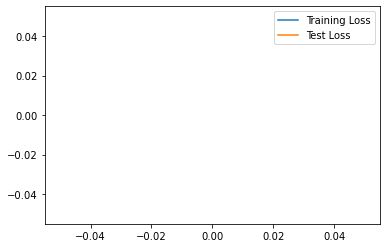

In [9]:
train_history, test_history = train(deep_hedger, derivative, risk_measure, optimizer, 
                                    price=price, n_samples=n_samples, validation_samples=validation_samples, n_epochs=n_epochs, batch_size=batch_size)
plt.plot(train_history, label='Training Loss')
plt.plot(test_history, label='Test Loss')
plt.legend()
plt.show()

In [10]:
if saving_model:
    save_model(deep_hedger, file_name, path)
    print('model saved!')

## Results

Having trained our model, it is time to compare its PnL performance with our benchmark.

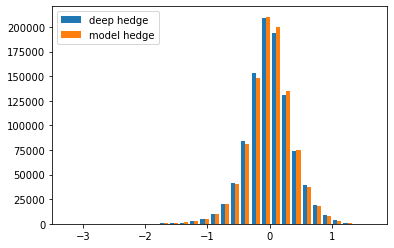

In [11]:
compare_to_black_scholes_hedger(deep_hedger, derivative=derivative, sigma=sigma,
                                risk_measure=risk_measure, n_samples=validation_samples, price=q, device=my_device,
                                labels=['deep hedge', 'model hedge'])

We observe that the hedging error for $\delta^{\text{BS}}$ and $\delta^{\theta}$ is very similar.

Moreover, our algorithm computes the following price for $p^\theta_0$:

In [12]:
p_0 = deep_hedger.price(derivative=derivative, risk_measure=risk_measure, n_samples=validation_samples)
print('The computed price for p_0 is {:.4f}.'.format(p_0))

The computed price for p_0 is 2.5598.
